找到 3 个文件，开始分析...
检测到变化的超参数: ['CHANNELS']
Accuracy对比图已保存为: accuracy_comparison_only.pdf


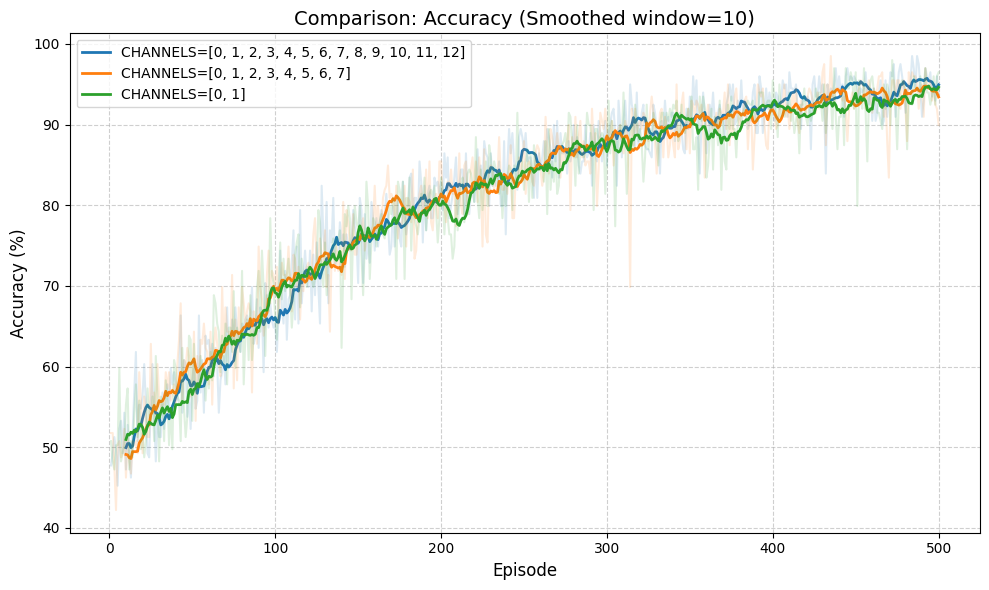

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

def parse_log_file(filepath):
    """
    读取特定的日志CSV文件，分离超参数和训练数据。
    (保持不变)
    """
    params = {}
    data_start_line = 0
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        for i, line in enumerate(lines):
            line = line.strip()
            if "--- Training Data ---" in line:
                data_start_line = i + 1
                break
            
            if ',' in line and "---" not in line and line:
                parts = line.split(',', 1) 
                if len(parts) >= 2:
                    key = parts[0].strip()
                    value = parts[1].strip()
                    if value.startswith('"') and value.endswith('"'):
                        value = value[1:-1]
                    params[key] = value
                    
        df = pd.read_csv(filepath, skiprows=data_start_line)
        return params, df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None, None

def plot_accuracy_only(folder_path='.', smoothing_window=10):
    """
    对比文件夹内所有CSV文件，仅绘制 Accuracy (%) 曲线
    """
    # 1. 获取所有csv文件
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    if not csv_files:
        print(f"在 '{folder_path}' 中没有找到 .csv 文件。")
        return

    print(f"找到 {len(csv_files)} 个文件，开始分析...")
    
    experiments = [] 

    # 2. 加载数据
    for f in csv_files:
        params, df = parse_log_file(f)
        if df is not None and not df.empty:
            experiments.append({
                'filename': os.path.basename(f),
                'params': params,
                'df': df
            })
    
    if not experiments:
        print("没有读取到有效的实验数据。")
        return

    # 3. 找出不同的超参数用于图例
    all_keys = set()
    for exp in experiments:
        all_keys.update(exp['params'].keys())
    
    diff_keys = []
    for key in all_keys:
        values = set(exp['params'].get(key, 'N/A') for exp in experiments)
        if len(values) > 1: 
            diff_keys.append(key)
            
    print(f"检测到变化的超参数: {diff_keys}")

    # --- 核心修改：只创建一张图 ---
    plt.figure(figsize=(10, 6)) # 设置单张图片的大小
    
    colors = plt.cm.tab10.colors 
    
    for i, exp in enumerate(experiments):
        df = exp['df']
        params = exp['params']
        
        # 生成图例
        if diff_keys:
            label_parts = [f"{k}={params.get(k, 'N/A')}" for k in diff_keys]
            label = ", ".join(label_parts)
        else:
            label = exp['filename']
            
        color = colors[i % len(colors)]
        
        # 绘制 Accuracy
        # 1. 原始数据背景 (透明)
        plt.plot(df['Episode'], df['Accuracy (%)'], color=color, alpha=0.15)
        
        # 2. 平滑数据前景 (实线)
        if len(df) > smoothing_window:
            smoothed_acc = df['Accuracy (%)'].rolling(window=smoothing_window).mean()
            plt.plot(df['Episode'], smoothed_acc, color=color, label=label, linewidth=2)
        else:
            plt.plot(df['Episode'], df['Accuracy (%)'], color=color, label=label, linewidth=2)

    # --- 设置图表样式 ---
    plt.title(f'Comparison: Accuracy (Smoothed window={smoothing_window})', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xlabel('Episode', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10, loc='best') # 自动寻找最佳位置放图例
    
    plt.tight_layout()
    
    # 保存结果
    output_filename = 'accuracy_comparison_only.pdf'
    plt.savefig(output_filename, dpi=300)
    print(f"Accuracy对比图已保存为: {output_filename}")
    plt.show()

# --- 运行脚本 ---
if __name__ == "__main__":
    plot_accuracy_only(folder_path='.')